In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import animation

(100, 3, 1000)


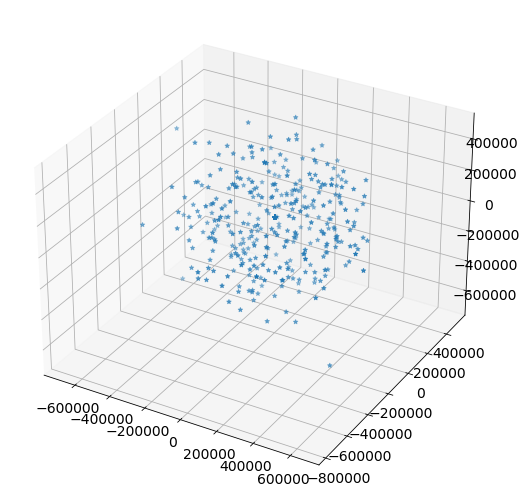

In [26]:
plt.rcParams.update({"font.size":14})
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(projection='3d')

def animate(fig,idx,im,pos):
    im._offset3d = (pos[idx,0,:],pos[idx,1,:], pos[idx,2,:])
    #fig.suptitle(df+', time:{:.2f} (Gyr), sgr dist:{:.2f}'.format(t[idx], sgr_orbit[idx]))

pos = []
vel = []
for i in range(1,101):
    h5file = h5py.File("build/leap_frog_test_grav_"+str(i)+".hdf5")
    pos.append(h5file["particles"][0,:,:])
    vel.append(h5file["particles"][1,:,:])
    
    #ax.hist(h5file["particles"][0,0,:], alpha=0.8, label='x')
    #ax.hist(h5file["particles"][0,1,:], alpha=0.8, label='y')
    #ax.hist(h5file["particles"][0,2,:], alpha=0.8, label='z')

pos = np.array(pos)
vel = np.array(vel)
print(pos.shape)
im = ax.scatter(pos[2,0,:], pos[2,1,:], pos[2,2,:], marker='*')
ax.grid()

#animation.FuncAnimation(fig, lambda idx : animate(fig,idx,im,pos),blit=False, interval=25, frames=100, repeat_delay=300) 
plt.show()